BloomTech Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

## Assignment

Complete these tasks for your assignment/project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. Review requirements for your portfolio project on Canvas, and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [ ]:
# Target: Highest-monthly earning
# Regression
# MAE
# We'll do test for with and without outliers, and be conducting a random split

# Imports

> Indented block



In [ ]:
%%capture
!pip install category_encoders==2.*
!pip install xgboost==1.3.2
!pip install pdpbox
!pip install shap

In [ ]:
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', None)
import matplotlib.pyplot as plt

from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance

from pdpbox.pdp import PDPIsolate, PDPInteract
from pdpbox.info_plots import TargetPlot, InteractTargetPlot
import shap
import warnings

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving globalYT.csv to globalYT.csv


In [ ]:
df = pd.read_csv('globalYT.csv', encoding = 'latin1')

# 1. Wrangle


In [ ]:
def wrangle(filepath):
    df = pd.read_csv(filepath, encoding = 'latin1', index_col = 'rank')
    # dropping columns with null and un-needed data
    df.drop(columns = ['Abbreviation', 'Latitude', 'Longitude',
                       'created_month', 'created_date', 'created_year',
                       'country_rank', 'channel_type', 'Gross tertiary education enrollment (%)',
                       'Unemployment rate',	'Urban_population','Population', 'Title', 'Youtuber'], inplace = True)

    df.drop(df[ (df['uploads'] <= 20)].index , inplace = True)

    # filling null with 0 and Unknown
    df['subscribers_for_last_30_days'].fillna(0, inplace=True)
    df['video_views_for_the_last_30_days'].fillna(0, inplace =True)
    df['channel_type_rank'].fillna(0, inplace = True)
    df['Country'].fillna('Unknown', inplace = True)
    df['category'].fillna('Unknown', inplace = True)

    #possible leaky columns: lowest_monthly_earnings, lowest_yearly_earnings, highest_yearly_earnings



    return df

In [ ]:
df = wrangle('globalYT.csv')


In [ ]:
df

,subscribers,video views,category,uploads,Country,video_views_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,lowest_yearly_earnings,highest_yearly_earnings,subscribers_for_last_30_days
rank,,,,,,,,,,,,,
1,245000000,2.280000e+11,Music,20082,India,1.0,1.0,2.258000e+09,564600.00,9000000.00,6800000.00,1.084000e+08,2000000.0
3,166000000,2.836884e+10,Entertainment,741,United States,48.0,1.0,1.348000e+09,337000.00,5400000.00,4000000.00,6.470000e+07,8000000.0
4,162000000,1.640000e+11,Education,966,United States,2.0,1.0,1.975000e+09,493800.00,7900000.00,5900000.00,9.480000e+07,1000000.0
5,159000000,1.480000e+11,Shows,116536,India,3.0,2.0,1.824000e+09,455900.00,7300000.00,5500000.00,8.750000e+07,1000000.0
7,112000000,9.324704e+10,People & Blogs,1111,United States,5.0,3.0,7.316740e+08,182900.00,2900000.00,2200000.00,3.510000e+07,0.0
8,111000000,2.905804e+10,Gaming,4716,Japan,44.0,4.0,3.918400e+07,9800.00,156700.00,117600.00,1.900000e+06,0.0
9,106000000,9.047906e+10,People & Blogs,493,Russia,630.0,25.0,4.894700e+07,12200.00,195800.00,146800.00,2.300000e+06,100000.0
10,98900000,7.718017e+10,Entertainment,574,United States,8.0,6.0,5.805740e+08,145100.00,2300000.00,1700000.00,2.790000e+07,600000.0
11,96700000,5.785629e+10,Music,8548,India,12.0,2.0,8.036130e+08,200900.00,3200000.00,2400000.00,3.860000e+07,1100000.0


In [ ]:
df.iloc[544]

Youtuber                            Kashvi Adlakha
subscribers                               15500000
video views                          12714141740.0
category                             Entertainment
Title                               Kashvi Adlakha
uploads                                       1525
Country                                      India
video_views_rank                             300.0
channel_type_rank                            141.0
video_views_for_the_last_30_days       139123000.0
lowest_monthly_earnings                    34800.0
highest_monthly_earnings                  556500.0
lowest_yearly_earnings                    417400.0
highest_yearly_earnings                  6700000.0
subscribers_for_last_30_days              200000.0
Name: 636, dtype: object

In [ ]:
df.isnull().sum()

subscribers                         0
video views                         0
category                            0
uploads                             0
Country                             0
video_views_rank                    0
channel_type_rank                   0
video_views_for_the_last_30_days    0
lowest_monthly_earnings             0
highest_monthly_earnings            0
lowest_yearly_earnings              0
highest_yearly_earnings             0
subscribers_for_last_30_days        0
dtype: int64

In [ ]:
# # used to identify null in specific columns
# df.loc[df['Population'].isnull()]


In [ ]:
pdp_isolate = PDPIsolate
pdp_plot = TargetPlot
pdp_interact = PDPInteract
pdp_interact_plot = InteractTargetPlot

# 2. Splitting Data



In [ ]:
target = 'highest_monthly_earnings'
y = df[target]
X = df.drop(columns = target)

In [ ]:
X.shape, y.shape

((874, 12), (874,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

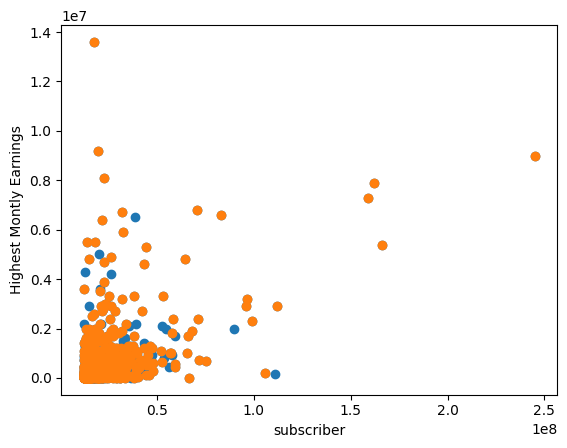

In [ ]:
plt.scatter(X['subscribers'], y)
plt.scatter(X_train['subscribers'],y_train)
plt.xlabel('subscriber')
plt.ylabel('Highest Montly Earnings');

In [ ]:
# Baseline Metrics
y_pred_baseline = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)

print('Highest Earning to Subscribers:',y_train.mean())
print('Baseline MAE:',baseline_mae)

Highest Earning to Subscribers: 674958.6820886981
Baseline MAE: 683929.9378263246


In [ ]:
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LinearRegression()

)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['category', 'Country'])),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [ ]:
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))

Training MAE: 4840.4347906405255
Test MAE: 6736.943279594381


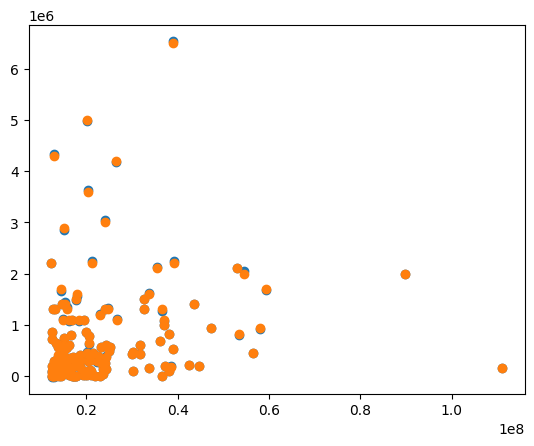

In [ ]:
plt.scatter(X_test['subscribers'], model.predict(X_test))
plt.scatter(X_test['subscribers'], y_test)


In [ ]:
model_xgb = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy = 'mean'),
    XGBRegressor(random_state = 42, n_estimators = 50, n_jobs = -1)
)

model_xgb.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['category', 'Country'])),
                ('simpleimputer', SimpleImputer()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=50,
                              n_jobs=-1, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [ ]:
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Testing Accuracy', model_xgb.score(X_test, y_test))

Training Accuracy 0.9999935676474508
Validation Accuracy 0.9931057943369858


In [ ]:
# Step 1: Choose my feature
column_to_permute = 'video views'

# Step 2: Train model w/ ALL features
model_to_permute = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    XGBRegressor(n_estimators=50,
                  random_state=42,
                  n_jobs=-1,)
)

model_to_permute.fit(X_train, y_train);

In [ ]:
print('Validation Accuracy', model_to_permute.score(X_test, y_test))

Validation Accuracy 0.9931057943369858


In [ ]:
X_test_perm = X_test.copy()
X_test_perm[column_to_permute] = np.random.permutation(X_test_perm[column_to_permute])

In [ ]:
print('Validation Accuracy', model_to_permute.score(X_test_perm, y_test))

Validation Accuracy 0.9931318791392317


In [ ]:
perm_imp = permutation_importance(model_to_permute, X_test, y_test, random_state = 42)

In [ ]:
perm_imp

{'importances_mean': array([ 3.42840984e-03,  3.58787061e-05, -2.16456823e-04, -4.12974979e-05,
        -4.70119984e-03, -1.80379122e-05, -6.41207369e-04,  1.16305132e-01,
         1.35799836e+00,  1.65813944e-04,  0.00000000e+00, -2.65001591e-04]),
 'importances_std': array([1.44846192e-03, 1.92377189e-05, 8.93390163e-05, 2.78939305e-05,
        2.57361047e-05, 1.52072078e-05, 2.48684408e-04, 1.02803415e-02,
        1.12592615e-01, 1.95265135e-05, 0.00000000e+00, 2.57673903e-04]),
 'importances': array([[ 5.66317420e-03,  4.64087234e-03,  2.10611094e-03,
          2.26634943e-03,  2.46554232e-03],
        [-5.72200314e-07,  4.87873866e-05,  3.74601485e-05,
          5.43259435e-05,  3.93922522e-05],
        [-5.98042251e-05, -2.63575687e-04, -3.27012448e-04,
         -2.37440143e-04, -1.94451610e-04],
        [-3.84594970e-05,  7.99863691e-06, -7.72977351e-05,
         -4.57571481e-05, -5.29717464e-05],
        [-4.67422193e-03, -4.71398748e-03, -4.74236186e-03,
         -4.70117419e-

In [ ]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_test.columns).sort_values('imp_mean')

In [ ]:
df_perm

,imp_mean,imp_std
Country,-0.004701,0.000026
channel_type_rank,-0.000641,0.000249
subscribers_for_last_30_days,-0.000265,0.000258
category,-0.000216,0.000089
uploads,-0.000041,0.000028
video_views_rank,-0.000018,0.000015
highest_yearly_earnings,0.000000,0.000000
video views,0.000036,0.000019
lowest_yearly_earnings,0.000166,0.000020
subscribers,0.003428,0.001448


<Axes: >

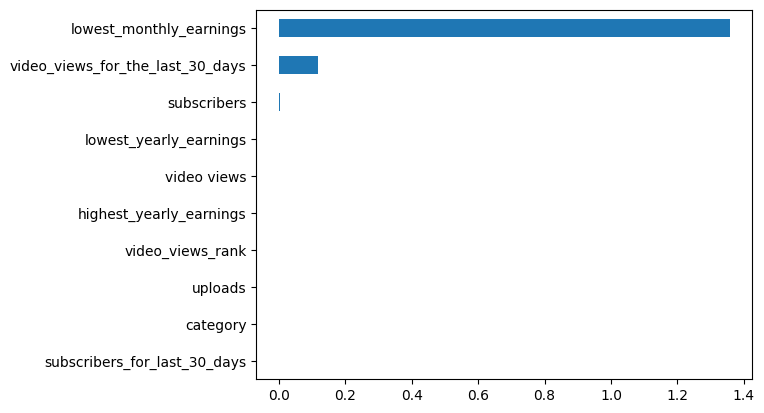

In [ ]:
df_perm['imp_mean'].tail(10).plot(kind='barh')

In [ ]:
sample_feature = 'lowest_monthly_earnings'

isolate = pdp_isolate(
    model_xgb,
    df = X_test,
    model_features = X_test.columns,
    feature_name = 'lowest_monthly_earnings',
    feature = sample_feature,
    n_classes = 0
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
fig, axes = isolate.plot()
fig

In [ ]:
sample_row = X_test.tail(1)

In [ ]:
# explainer = shap.TreeExplainer(model_xgb)
# shap_values = explainer.shap_values(sample_row)

# #initialization of java script
# shap.initjs()

# shap.force_plot(
#     base_value = explainer.expected_value,
#     shap_values = shap_values,
#     features = sample_row
# )

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

Wanted to choose this specific data set of Youtube Statistics because - Wanted to find out the relations between different data point. Personally watching a lot of youtube, I find that it would interesting to know different information and how that effects a creator's earning.

Performed Data exploration
cleaned up dataset/removed all un-needed data
Split baseline/set baseline accuracy
goal was to find correlation between highest earning and other categories
linear regression model was use because based on the data set, and it being a regression problem - I chose linear regression for the first model
used XGBRegressor for boosting model.
based on the accuracy score - we can see that the model is preforming very well. this is probably due to the strong correlation between the features and the target.

We can also see a strong correltion the lowest_monthly_earning and target which is the highest earning.